## Load Raw Data into Train/Val/Test sets and Save
This also has the ability to write the raw data files into train/validate/test files.  These files only contain the raw TLE data.  Extra pre-processing is still required as well as the assembly of input/label data.

In [1]:
from load_data import *

In [2]:
norad_lists = load_norads(['train','validate','secret_test'])

In [3]:
%time df_dict = load_data(norad_lists, use_all_data=True, debug=True, multiproc=True)  # Takes about 4min

Loading files from path: /mistorage/mads/data/gp_history


  0%|          | 0/3 [00:00<?, ?it/s]

Finished loading.


100%|██████████| 3/3 [00:26<00:00,  8.78s/it]

Finished assembling.
CPU times: user 57.4 s, sys: 35.1 s, total: 1min 32s
Wall time: 1min 59s


In [4]:
%time write_data(df_dict, use_all_data=True, debug=True, threaded=True, path='data')

Saving files to path: data
Writing raw data for to: data/train.pkl
Writing raw data for to: data/test.pkl
Writing raw data for to: data/secret_test.pkl
Finished saving data/test.pkl
Finished saving data/secret_test.pkl
Finished saving data/train.pkl
CPU times: user 1min 6s, sys: 24.8 s, total: 1min 31s
Wall time: 1min 50s


In [4]:
norad_lists = load_norads(['train','validate'])
df_dict = load_data(norad_lists, use_all_data=False, debug=True, multiproc=True)
write_data(df_dict, use_all_data=False, debug=True, threaded=True)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Loading files from path: C:\Users\mille\Documents\tle-prediction/data/space-track-gp-hist-sample


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 45.48it/s]

Finished loading.


Finished assembling.
Saving files to path: C:\Users\mille\Documents\tle-prediction/data/space-track-gp-hist-sample/raw_compiled
Writing raw data for to: C:\Users\mille\Documents\tle-prediction/data/space-track-gp-hist-sample/raw_compiled/train.pkl
Writing raw data for to: C:\Users\mille\Documents\tle-prediction/data/space-track-gp-hist-sample/raw_compiled/test.pkl
Finished saving C:\Users\mille\Documents\tle-prediction/data/space-track-gp-hist-sample/raw_compiled/test.pkl
Finished saving C:\Users\mille\Documents\tle-prediction/data/space-track-gp-hist-sample/raw_compiled/train.pkl


## Analyze Full Data

In [17]:
%time df = pd.read_pickle('data/train.pkl') 

CPU times: user 14.6 s, sys: 10.8 s, total: 25.4 s
Wall time: 25.4 s


In [19]:
import clean_data

%time df = clean_data.add_epoch_data(df)
%time df = clean_data.normalize_all_columns(df)

CPU times: user 4min 51s, sys: 18 s, total: 5min 10s
Wall time: 5min 10s
CPU times: user 5.46 s, sys: 4.36 s, total: 9.82 s
Wall time: 9.82 s


In [23]:
df.epoch_jd.min()

2437162.5

In [24]:
df.epoch_jd.max(), df.epoch_jd.min()

(2459309.5, 2437162.5)

In [ ]:
2437162.5

## Load Raw Train set and train/test a model

In [1]:
import pandas as pd
import numpy as np
import os

files = ['train']

model_cols = ['BSTAR', 'INCLINATION', 'RA_OF_ASC_NODE', 'ECCENTRICITY', 'ARG_OF_PERICENTER', 'MEAN_ANOMALY',
              'MEAN_MOTION', 'epoch_jd', 'epoch_fr',
              #'MEAN_MOTION_DOT', 'MEAN_MOTION_DDOT', 
             ]

#%time df = pd.read_pickle(os.environ['GP_HIST_PATH'] + '/raw_compiled/train.pkl' )  # Takes about 20s
train_df = pd.read_pickle(os.environ['my_home_path'] + '/data/space-track-gp-hist-sample/raw_compiled/train.pkl' )
test_df = pd.read_pickle(os.environ['my_home_path'] + '/data/space-track-gp-hist-sample/raw_compiled/test.pkl' )

In [2]:
train_df[model_cols[:-2]].head()

,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
0,0.002592,62.2415,180.1561,0.070489,265.6761,86.2771,12.852684
1,0.000100,73.3600,345.6887,0.008815,270.3999,88.6911,12.642166
2,0.001076,83.0239,250.9465,0.008493,184.3222,175.7249,13.856401
3,0.000166,70.9841,207.4830,0.020756,161.3777,199.5075,13.715209
4,0.000739,90.1460,192.1834,0.002746,300.4617,59.3655,12.992417


In [3]:
%%time
import clean_data

for df in [train_df, test_df]:
    df = clean_data.add_epoch_data(df)
    df = clean_data.normalize_all_columns(df)
    
train_idx_map = clean_data.create_index_map(train_df)
test_idx_map = clean_data.create_index_map(test_df)

train_df = train_df[model_cols]
test_df = test_df[model_cols]

100%|██████████| 599/599 [00:00<00:00, 2599.80it/s]

CPU times: user 2.34 s, sys: 103 ms, total: 2.44 s
Wall time: 2.42 s


In [4]:
train_df.head()

,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION,epoch_jd,epoch_fr
0,0.051838,0.345786,0.500434,0.413086,0.737989,0.239659,-0.406934,0.720639,0.596391
1,0.002000,0.407556,0.960246,0.206575,0.751111,0.246364,-0.502072,0.720639,0.666444
2,0.021510,0.461244,0.697074,0.204030,0.512006,0.488125,0.046666,0.720639,0.823075
3,0.003313,0.394356,0.576342,0.274821,0.448271,0.554187,-0.017142,0.720639,0.654993
4,0.014780,0.500811,0.533843,0.140034,0.834616,0.164904,-0.343786,0.720639,0.154908


In [10]:
import train

model = train.train_model(train_df, train_idx_map, batchSize=2000,
                          print_itr=10, numEpochs=30, model_cols=model_cols,
                          learningRate=0.0001)

>>> Loading model
>>> Loading dataset
>>> Beginning training!
Epoch [1/30], Step [10/54], Loss: 0.431788831949234, Time: 0s
Epoch [1/30], Step [20/54], Loss: 0.39289823174476624, Time: 0s
Epoch [1/30], Step [30/54], Loss: 0.35972344875335693, Time: 0s
Epoch [1/30], Step [40/54], Loss: 0.3272292912006378, Time: 0s
Epoch [1/30], Step [50/54], Loss: 0.2945675253868103, Time: 0s
Epoch [2/30], Step [10/54], Loss: 0.2564551830291748, Time: 0s
Epoch [2/30], Step [20/54], Loss: 0.23016968369483948, Time: 0s
Epoch [2/30], Step [30/54], Loss: 0.2129240781068802, Time: 0s
Epoch [2/30], Step [40/54], Loss: 0.20349764823913574, Time: 0s
Epoch [2/30], Step [50/54], Loss: 0.1913577765226364, Time: 0s
Epoch [3/30], Step [10/54], Loss: 0.1840883493423462, Time: 0s
Epoch [3/30], Step [20/54], Loss: 0.17861193418502808, Time: 0s
Epoch [3/30], Step [30/54], Loss: 0.18185508251190186, Time: 0s
Epoch [3/30], Step [40/54], Loss: 0.16850771009922028, Time: 0s
Epoch [3/30], Step [50/54], Loss: 0.16030347347259

Epoch [26/30], Step [30/54], Loss: 0.08485129475593567, Time: 0s
Epoch [26/30], Step [40/54], Loss: 0.08446333557367325, Time: 0s
Epoch [26/30], Step [50/54], Loss: 0.08618029206991196, Time: 0s
Epoch [27/30], Step [10/54], Loss: 0.08336710184812546, Time: 0s
Epoch [27/30], Step [20/54], Loss: 0.08602552115917206, Time: 0s
Epoch [27/30], Step [30/54], Loss: 0.08635948598384857, Time: 0s
Epoch [27/30], Step [40/54], Loss: 0.08264032751321793, Time: 0s
Epoch [27/30], Step [50/54], Loss: 0.08689428865909576, Time: 0s
Epoch [28/30], Step [10/54], Loss: 0.08458703011274338, Time: 0s
Epoch [28/30], Step [20/54], Loss: 0.08697458356618881, Time: 0s
Epoch [28/30], Step [30/54], Loss: 0.080739825963974, Time: 0s
Epoch [28/30], Step [40/54], Loss: 0.08592489361763, Time: 0s
Epoch [28/30], Step [50/54], Loss: 0.08219888806343079, Time: 0s
Epoch [29/30], Step [10/54], Loss: 0.08381830900907516, Time: 0s
Epoch [29/30], Step [20/54], Loss: 0.07938660681247711, Time: 0s
Epoch [29/30], Step [30/54], L

In [22]:
model.eval()

NNModel(
  (activate): ReLU()
  (layer1): Linear(in_features=11, out_features=300, bias=True)
  (layer2): Linear(in_features=300, out_features=7, bias=True)
)

In [12]:
X_train,y_train = clean_data.build_xy(train_df,train_idx_map)  # create input/label pair

### NN Train set compare

In [13]:
clean_data.normalize_all_columns(y_train.head().copy(), reverse=True)

,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
0,0.000348,62.2191,259.1885,0.075963,30.7963,333.5385,12.793112
1,-0.000532,62.2294,246.6045,0.075994,31.8523,332.6171,12.793099
2,0.000792,62.2174,271.0315,0.076050,29.6474,334.5457,12.793093
3,0.000764,62.2231,256.9352,0.075979,30.9451,333.4093,12.793136
4,0.000782,62.2225,280.6188,0.075972,28.8714,335.2148,12.793035


In [14]:
y_pred = train.predict(model, X_train) # get predictions for each train
y_pred_df = pd.DataFrame(y_pred, columns=train_df.columns[:-2])  # put results into a dataframe
clean_data.normalize_all_columns(y_pred_df, reverse=True)  # reverse the normalization

,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
0,0.001442,62.141991,123.024567,0.071378,258.574524,94.575180,12.824528
1,0.000326,62.288033,254.974823,0.075728,54.885559,314.655731,12.811526
2,-0.000312,61.643177,242.891251,0.075587,51.064476,312.381592,12.798881
3,0.000750,61.862446,259.703003,0.076210,52.115757,311.058472,12.807513
4,0.000717,62.101624,249.421082,0.075002,56.156261,312.619720,12.811118
...,...,...,...,...,...,...,...
109045,0.050927,96.796440,183.788910,0.043135,216.390381,130.168488,11.880613
109046,0.050487,93.760315,193.836792,0.041936,197.745880,156.150864,11.893438
109047,0.050522,93.214455,181.239670,0.042515,224.022049,124.738899,11.881270
109048,0.000187,99.678818,260.238190,0.002600,248.810959,120.952049,15.918059


### NN Test set compare

In [28]:
X_test,y_test = clean_data.build_xy(test_df,test_idx_map)  # create input/label pair
display(y_test.head())
clean_data.normalize_all_columns(y_test.head().copy(), reverse=True)

,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
0,0.003380,0.551259,0.276470,0.189922,0.499860,0.500463,0.060020
1,0.003445,0.551246,0.252900,0.189721,0.564069,0.435398,0.060006
2,0.004778,0.551248,0.230931,0.189351,0.624581,0.374210,0.059991
3,0.005625,0.551248,0.225388,0.189421,0.639408,0.359251,0.059987
4,0.003517,0.551246,0.236473,0.189427,0.609416,0.389529,0.059992


,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
0,0.000169,99.2266,99.5291,0.006851,179.9495,180.1667,13.885950
1,0.000172,99.2243,91.0439,0.006829,203.0647,156.7433,13.885920
2,0.000239,99.2247,83.1351,0.006789,224.8491,134.7155,13.885887
3,0.000281,99.2246,81.1396,0.006796,230.1867,129.3303,13.885878
4,0.000176,99.2243,85.1301,0.006797,219.3898,140.2303,13.885889


In [29]:
y_pred = train.predict(model, X_test) # get predictions for each train
display(y_pred[:5])
y_pred_df = pd.DataFrame(y_pred, columns=test_df.columns[:-2])  # put results into a dataframe
clean_data.normalize_all_columns(y_pred_df.head().copy(), reverse=True)  # reverse the normalization

array([[0.00413666, 0.55812556, 0.24479508, 0.18703708, 0.6224622 ,
        0.37671435, 0.05994278],
       [0.00746519, 0.5489638 , 0.31612125, 0.19124953, 0.5021574 ,
        0.49961573, 0.05842556],
       [0.0034388 , 0.55059206, 0.2716665 , 0.19236389, 0.558126  ,
        0.44537652, 0.05718892],
       [0.00297778, 0.55145466, 0.25098363, 0.19087628, 0.61132586,
        0.39180404, 0.05554563],
       [0.00417776, 0.5511606 , 0.24772531, 0.19124085, 0.62371963,
        0.380395  , 0.0552419 ]], dtype=float32)

,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
0,0.000207,100.462601,88.126228,0.006543,224.086395,135.617172,13.885780
1,0.000373,98.813484,113.803650,0.006995,180.776657,179.861664,13.882423
2,0.000172,99.106575,97.799942,0.007118,200.925354,160.335541,13.879687
3,0.000149,99.261841,90.354103,0.006954,220.077316,141.049454,13.876051
4,0.000209,99.208900,89.181114,0.006994,224.539062,136.942200,13.875379


# Compare to Linear Regression

In [12]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(n_jobs=-1).fit(X_train, y_train)

In [13]:
y_pred = model.predict(X_train)
y_pred_df = pd.DataFrame(y_pred, columns=train_df.columns[:-2])  # put results into a dataframe
clean_data.normalize_all_columns(y_pred_df, reverse=True)  # reverse the normalization

,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
0,0.004720,62.220821,207.988530,0.075262,116.288822,245.203602,12.800794
1,0.003152,62.207872,227.592242,0.070809,120.771444,240.726320,12.925240
2,0.002993,62.230592,156.526929,0.074853,215.537640,141.776021,12.731105
3,0.003171,62.220463,222.008220,0.075210,117.214914,244.106022,12.805979
4,0.003539,62.235029,203.636752,0.075459,117.986090,243.444264,12.796448
...,...,...,...,...,...,...,...
109045,0.033622,101.039250,196.580265,0.054166,190.215450,170.105630,11.886281
109046,0.033553,101.057133,174.010652,0.052683,197.321385,162.855008,11.869131
109047,0.033572,101.058482,178.256434,0.052550,194.799120,165.366205,11.875029
109048,-0.001393,100.023770,214.574038,0.004324,187.965364,171.721197,15.957305


In [14]:
y_pred = model.predict(X_test)
y_pred_df = pd.DataFrame(y_pred, columns=test_df.columns[:-2])  # put results into a dataframe
clean_data.normalize_all_columns(y_pred_df, reverse=True)  # reverse the normalization

,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION
0,0.000366,99.224188,139.833114,0.006853,188.659731,171.299229,13.878915
1,-0.000131,99.209701,138.430531,0.005883,211.349598,148.460393,14.003572
2,0.000567,99.372810,139.498792,0.006722,191.084679,169.373722,13.891591
3,0.001257,99.387116,147.134252,0.007815,159.033098,201.818963,13.765876
4,0.000351,99.224501,134.533664,0.006813,199.704657,160.046821,13.879596
...,...,...,...,...,...,...,...
21412,0.007643,65.713528,198.066050,0.080839,176.320242,183.752995,12.199382
21413,0.005921,65.696123,186.512272,0.077344,172.842349,187.221681,12.201514
21414,0.005602,65.698218,187.471695,0.077459,173.159382,186.892891,12.201886
21415,0.007207,65.693446,194.115021,0.077326,174.170208,185.750698,12.202774


## Distribution of Raw Columns

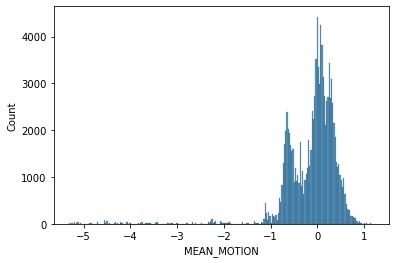

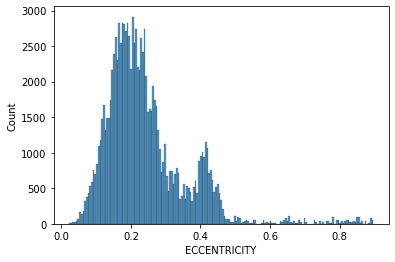

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df,x='MEAN_MOTION')
plt.show()

sns.histplot(df,x='ECCENTRICITY')
plt.show()

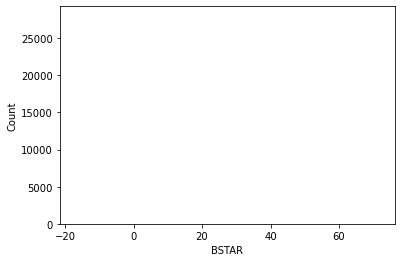

In [6]:
sns.histplot(df,x='BSTAR')
plt.show()

## Load Cleaned data

In [1]:
import pandas as pd
import os

files = ['train']
model_cols = ['MEAN_MOTION_DOT', 'MEAN_MOTION_DDOT', 'BSTAR', 'INCLINATION', 'RA_OF_ASC_NODE',
              'ECCENTRICITY', 'ARG_OF_PERICENTER', 'MEAN_ANOMALY', 'MEAN_MOTION', 'epoch_jd', 'epoch_fr']

%time df = pd.read_pickle(os.environ['GP_HIST_PATH'] + '/cleaned/train_clean.pkl')  # Takes about 20s

Wall time: 26.6 s


In [5]:
df[model_cols].head()

,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION,epoch_jd,epoch_fr
0,1.801000e-05,0.0,0.002592,62.2415,180.1561,0.070489,265.6761,86.2771,12.852684,2453122.5,0.596391
1,-2.000000e-08,0.0,0.000100,73.3600,345.6887,0.008815,270.3999,88.6911,12.642166,2453122.5,0.666444
2,1.280000e-05,0.0,0.001076,83.0239,250.9465,0.008493,184.3222,175.7249,13.856401,2453122.5,0.823075
3,1.320000e-06,0.0,0.000166,70.9841,207.4830,0.020756,161.3777,199.5075,13.715209,2453122.5,0.654993
4,2.280000e-06,0.0,0.000739,90.1460,192.1834,0.002746,300.4617,59.3655,12.992417,2453122.5,0.154908


In [2]:
df[model_cols].describe()

,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION,epoch_jd,epoch_fr
count,5.489969e+07,5.489969e+07,5.489969e+07,5.489969e+07,5.489969e+07,5.489969e+07,5.489969e+07,5.489969e+07,5.489969e+07,5.489969e+07,5.489969e+07
mean,1.560643e-04,5.485870e-01,1.459784e-03,8.419035e+01,1.801053e+02,2.158388e-02,1.784617e+02,1.812822e+02,1.375314e+01,2.454094e+06,5.318159e-01
std,3.745641e-03,1.782031e+03,5.064926e-02,1.819075e+01,1.038900e+02,4.841379e-02,1.038260e+02,1.055550e+02,2.212779e+00,4.091497e+03,2.969824e-01
min,-1.000000e+00,-3.086700e-01,-2.618100e+01,9.900000e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.981056e-01,2.437162e+06,0.000000e+00
25%,6.400000e-07,0.000000e+00,1.000000e-04,7.099900e+01,9.012995e+01,4.108700e-03,8.862640e+01,8.851405e+01,1.340196e+01,2.451312e+06,2.636590e-01
50%,4.820000e-06,0.000000e+00,2.594200e-04,8.913500e+01,1.801751e+02,9.078400e-03,1.769953e+02,1.823633e+02,1.398493e+01,2.454960e+06,5.449818e-01
75%,2.016000e-05,0.000000e+00,8.218200e-04,9.902480e+01,2.702199e+02,1.980150e-02,2.682896e+02,2.741587e+02,1.436245e+01,2.457680e+06,8.065955e-01
max,1.000000e+00,8.437400e+06,3.014907e+02,1.446946e+02,3.600000e+02,9.301648e-01,3.600000e+02,9.999999e+02,1.425793e+04,2.459298e+06,1.000000e+00


C:\ProgramData\Anaconda3\envs\cmtle\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


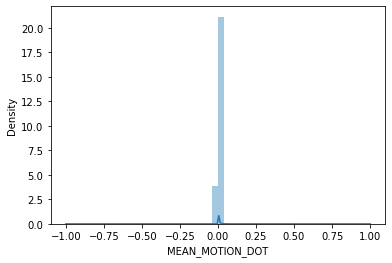

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(df['MEAN_MOTION_DOT']);

In [6]:
from pandas_profiling import ProfileReport

ModuleNotFoundError: No module named 'pandas_profiling'

## First model

In [10]:
import numpy as np

def create_index_map(df):
    '''
    This will create a map between an input record (for X_train) and
    a label record (for y_train) that will be used by the pytorch
    dataset class to dynamically build a dataset without taking up
    more space than is necessary.
    '''
    
    # ML Structure
    # Input:
    #  - Reference TLE Data (+ EPOCH)
    #  - Target EPOCH
    # Output:
    #  - Target TLE Data
    
    def groups(lst):
        arr = lst.copy()
        np.random.shuffle(arr)
        i=1
        if len(lst)<=1:
            return
        while True:
            if i==len(lst):
                yield tuple((arr[i-1],arr[0]))
                break
            else:
                yield tuple((arr[i-1],arr[i]))
                i+=1
    
    # For each unique NORAD, find all TLE indexes and generate
    # a list of combinations
    idx_pairs = []
    for norad in df['NORAD_CAT_ID'].unique():
        norad_idxs = df[df['NORAD_CAT_ID']==norad].index.values
        if len(norad_idxs > 1):
            idx_pairs.extend(groups(norad_idxs))
    idx_pairs = np.array(idx_pairs)
    
#     # Build our X/Y datasets
#     X_all = df.loc[idx_pairs[:,0]].reset_index()
#     Y_all = df.loc[idx_pairs[:,1]].reset_index()
    
#     # This will be the column that links x and y
#     key_columns = ['epoch_jd', 'epoch_fr']
#     target_columns = ['target_epoch_jd', 'target_epoch_fr']
#     X_all[target_columns] = Y_all[key_columns]
    
    return idx_pairs

%time idx_pairs = create_index_map(df)  # 16min - look at ways to improve this through parallelism/concurrency

Wall time: 10.6 s


In [11]:
# Test the dataset structure method
import torch

model_cols = ['MEAN_MOTION_DOT', 'MEAN_MOTION_DDOT', 'BSTAR', 'INCLINATION', 'RA_OF_ASC_NODE',
              'ECCENTRICITY', 'ARG_OF_PERICENTER', 'MEAN_ANOMALY', 'MEAN_MOTION', 'epoch_jd', 'epoch_fr']

tmp_df = df.iloc[:10][model_cols].copy()
t1 = torch.from_numpy(tmp_df.to_numpy())  # data
t2 = torch.tensor([(0,1),(1,2)])

index = 0
p = t2[index]
X = torch.cat((t1[p[0]], t1[p[1]][-2:]), 0)
y = t1[p[1]][:-2]
display(X)
display(y)

tensor([ 1.8010e-05,  0.0000e+00,  2.5919e-03,  3.4579e-01,  5.0043e-01,
         4.1309e-01,  7.3799e-01,  2.3966e-01, -4.0693e-01,  2.4531e+06,
         5.9639e-01,  2.4531e+06,  6.6644e-01], dtype=torch.float64)

tensor([-2.0000e-08,  0.0000e+00,  1.0000e-04,  4.0756e-01,  9.6025e-01,
         2.0657e-01,  7.5111e-01,  2.4636e-01, -5.0207e-01],
       dtype=torch.float64)

In [10]:
import torch
import torch.nn as nn
torch.manual_seed(0)

hiddenSize = 300
batchSize = 200
learningRate = 0.01
numEpochs = 10

model_cols = ['MEAN_MOTION_DOT', 'MEAN_MOTION_DDOT', 'BSTAR', 'INCLINATION', 'RA_OF_ASC_NODE',
              'ECCENTRICITY', 'ARG_OF_PERICENTER', 'MEAN_ANOMALY', 'MEAN_MOTION', 'epoch_jd', 'epoch_fr']

#device = torch.device('cpu')
device = torch.device('cuda')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, data, idx_pairs, device='cpu'):
        'Initialization'
        self.data = to_device(torch.from_numpy(data.to_numpy()).float(), device)
        self.idx_pairs = to_device(torch.from_numpy(idx_pairs).long(), device)

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.idx_pairs)

    def __getitem__(self, index):
        'Generates one sample of data'
        p = self.idx_pairs[index]
        
        # This will use the idx_pairs (x,y) to build the inputs(X) and labels (y)
        # output.  It adds the last 2 columns of y to X and removes them from y.
        X = torch.cat((self.data[p[0]], self.data[p[1]][-2:]), 0)
        y = self.data[p[1]][:-2]

        return X, y

In [11]:
class NNModel(nn.Module):
    def __init__(self, inputSize, outputSize, hiddenSize, activate=None):
        super().__init__()
        self.activate = nn.Sigmoid() if activate == "Sigmoid" else nn.Tanh() if activate == "Tanh" else nn.ReLU()
        self.layer1 = nn.Linear(inputSize, hiddenSize)
        self.layer2 = nn.Linear(hiddenSize, outputSize)

    def forward(self, X):
        hidden = self.activate(self.layer1(X))
        return self.layer2(hidden)
        
        
net = NNModel(len(model_cols) + 2, len(model_cols) - 2, hiddenSize)
to_device(net, device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(net.parameters(), lr=learningRate)

trainDataset = Dataset(df[model_cols], idx_pairs, device)
trainLoader = torch.utils.data.DataLoader(dataset=trainDataset,
                                          batch_size=batchSize,
                                          shuffle=True,
                                         )

In [12]:
%%time
print('>>> Beginning training!')
for epoch in range(numEpochs):
    for i, (inputs, labels) in enumerate(trainLoader):
        optimizer.zero_grad()
        # Forward propagation
        outputs = net(inputs)
        # Backpropagation
        loss = criterion(outputs, labels)
        loss.backward()
        # Gradient descent
        optimizer.step()
        # Logging
        if (i+1) % 1000 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {}'.format(epoch+1, numEpochs, i+1,
                                                                 len(trainDataset)//batchSize, loss))

>>> Beginning training!
Epoch [1/10], Step [1000/274498], Loss: 67.85113525390625
Epoch [1/10], Step [2000/274498], Loss: 61.399200439453125
Epoch [1/10], Step [3000/274498], Loss: 59.910133361816406
Epoch [1/10], Step [4000/274498], Loss: 55.3093376159668
Epoch [1/10], Step [5000/274498], Loss: 51.05797576904297
Epoch [1/10], Step [6000/274498], Loss: 47.72842025756836
Epoch [1/10], Step [7000/274498], Loss: 44.89704513549805
Epoch [1/10], Step [8000/274498], Loss: 43.87120819091797
Epoch [1/10], Step [9000/274498], Loss: 40.73126983642578
Epoch [1/10], Step [10000/274498], Loss: 39.8402099609375
Epoch [1/10], Step [11000/274498], Loss: 38.2437858581543
Epoch [1/10], Step [12000/274498], Loss: 36.390560150146484
Epoch [1/10], Step [13000/274498], Loss: 36.37118911743164
Epoch [1/10], Step [14000/274498], Loss: 35.300994873046875
Epoch [1/10], Step [15000/274498], Loss: 33.36863327026367
Epoch [1/10], Step [16000/274498], Loss: 34.209449768066406
Epoch [1/10], Step [17000/274498], Loss

KeyboardInterrupt: 

In [16]:
pd.DataFrame(idx_pairs,columns=['idx1','idx2']).to_csv(os.environ['GP_HIST_PATH'] + '/idx_pairs/train_idx_pairs.csv', index=False)

In [19]:
%time idx_pairs = pd.read_csv(os.environ['GP_HIST_PATH'] + '/idx_pairs/train_idx_pairs.csv').to_numpy()

Wall time: 7.57 s


In [18]:
idx_pairs

array([[15075076, 25553468],
       [25553468, 20818702],
       [20818702, 32231723],
       ...,
       [54898363, 54885991],
       [54885991, 54881418],
       [54881418, 54862939]], dtype=int64)